In [2]:
import numpy as np
import pandas as pd
import yfinance as yf

START_DATE = "2015-01-01"
END_DATE   = "2025-12-12"

hsi_stocks = pd.read_excel("/Users/henrywzh/Desktop/hk_stock_ejfq.xlsx")

def code_int_to_hk(code: int) -> str:
    return f"{int(code):04d}.HK"

UNIVERSE = hsi_stocks["代码"].apply(code_int_to_hk).tolist()

price_df = yf.download(UNIVERSE, START_DATE, END_DATE, auto_adjust=False, group_by="column")
hsi = yf.download("^HSI", START_DATE, END_DATE, auto_adjust=False)

# Extract close matrices
close = price_df["Close"].sort_index()
hsi_close = hsi["Close"].sort_index()

# Common calendar (optional but recommended)
common_dates = close.index.intersection(hsi_close.index)
close = close.loc[common_dates]
hsi_close = hsi_close.loc[common_dates]

[*********************100%***********************]  108 of 108 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
TRADING_DAYS = 252


# =========================
# Utilities
# =========================

def _sigmoid(x, scale=1.0):
    return 1.0 / (1.0 + np.exp(-(x / scale)))

def _safe_div(a, b):
    out = a / b
    out = out.replace([np.inf, -np.inf], np.nan)
    return out

def compute_ma(close: pd.DataFrame, windows) -> dict:
    return {w: close.rolling(w, min_periods=w).mean() for w in windows}

def compute_atr(price_df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    high = price_df["High"].sort_index()
    low = price_df["Low"].sort_index()
    close = price_df["Close"].sort_index()
    prev_close = close.shift(1)

    tr = pd.concat(
        [(high - low), (high - prev_close).abs(), (low - prev_close).abs()],
        axis=0
    ).groupby(level=0).max()

    atr = tr.rolling(window, min_periods=window).mean()
    return atr


# =========================
# Step 1) Market structure label (strong-trend vs rebound)
# =========================

def compute_market_structure_flag(price_df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns regime_flag per (date, ticker):
      +1 = strong trend (MA50>MA120>MA250 and all rising, price above MA50)
      -1 = rebound / downtrend backdrop (MA50,120,250 falling and price below MA50)
       0 = other / mixed
    """
    close = price_df["Close"].sort_index()
    ma = compute_ma(close, windows=(50, 120, 250))
    m50, m120, m250 = ma[50], ma[120], ma[250]

    slope50 = m50.diff()
    slope120 = m120.diff()
    slope250 = m250.diff()

    strong = (m50 > m120) & (m120 > m250) & (slope50 > 0) & (slope120 > 0) & (slope250 > 0) & (close > m50)
    rebound = (slope50 < 0) & (slope120 < 0) & (slope250 < 0) & (close < m50)

    flag = pd.DataFrame(0, index=close.index, columns=close.columns, dtype=np.int8)
    flag[strong] = 1
    flag[rebound] = -1
    return flag


# =========================
# Signal: System 1 continuous entry score
# =========================

def score_four_line_open(
    price_df: pd.DataFrame,
    delta_tight: float = 0.02,
    use_atr_scale: bool = True,
    w_order: float = 0.40,
    w_tight: float = 0.35,
    w_slope: float = 0.25,
) -> pd.DataFrame:
    close = price_df["Close"].sort_index()
    ma = compute_ma(close, windows=(5, 10, 20, 30))
    m5, m10, m20, m30 = ma[5], ma[10], ma[20], ma[30]

    if use_atr_scale and all(k in price_df.columns.get_level_values(0) for k in ["High", "Low", "Close"]):
        atr = compute_atr(price_df, window=14)
        tau = 0.5 * atr
        kappa = 0.2 * atr
    else:
        tau = 0.003 * close
        kappa = 0.001 * close

    # order
    d1, d2, d3 = (m5 - m10), (m10 - m20), (m20 - m30)
    s_order = (_sigmoid(d1, tau) + _sigmoid(d2, tau) + _sigmoid(d3, tau)) / 3.0

    # tightness dispersion
    mx = np.maximum.reduce([m5, m10, m20, m30])
    mn = np.minimum.reduce([m5, m10, m20, m30])
    D = _safe_div((mx - mn), close)
    s_tight = np.exp(-D / delta_tight)

    # slope
    dm5, dm10, dm20, dm30 = m5.diff(), m10.diff(), m20.diff(), m30.diff()
    s_slope = (_sigmoid(dm5, kappa) + _sigmoid(dm10, kappa) + _sigmoid(dm20, kappa) + _sigmoid(dm30, kappa)) / 4.0

    score_open = (w_order * s_order) + (w_tight * s_tight) + (w_slope * s_slope)
    return score_open.clip(0.0, 1.0)


def score_volume_ratio(
    price_df: pd.DataFrame,
    vol_window: int = 10,
    vr_center: float = 1.5,
    vr_scale: float = 0.4,
    cont_window: int = 3,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    vol = price_df["Volume"].sort_index()
    vma = vol.rolling(vol_window, min_periods=vol_window).mean()
    vr = _safe_div(vol, vma)

    s_vol = 1.0 / (1.0 + np.exp(-(vr - vr_center) / vr_scale))
    vr_min = vr.rolling(cont_window, min_periods=cont_window).min()
    s_cont = ((vr_min - 1.0) / max(1e-9, (vr_center - 1.0))).clip(0.0, 1.0)
    return s_vol, s_cont


def build_entry_score_system1(
    price_df: pd.DataFrame,
    delta_tight: float = 0.02,
    vol_window: int = 10,
    vr_center: float = 1.5,
    cont_window: int = 3,
    use_regime_filter: bool = False,
    regime_flag: pd.DataFrame | None = None,
    regime_mode: str = "strong_only",  # "strong_only" | "exclude_rebound" | "none"
) -> pd.DataFrame:
    score_open = score_four_line_open(price_df, delta_tight=delta_tight)
    s_vol, s_cont = score_volume_ratio(price_df, vol_window=vol_window, vr_center=vr_center, cont_window=cont_window)
    score_entry = (score_open * s_vol * s_cont).clip(0.0, 1.0)

    if use_regime_filter:
        if regime_flag is None:
            regime_flag = compute_market_structure_flag(price_df)

        if regime_mode == "strong_only":
            score_entry = score_entry.where(regime_flag == 1)
        elif regime_mode == "exclude_rebound":
            score_entry = score_entry.where(regime_flag != -1)
        elif regime_mode == "none":
            pass
        else:
            raise ValueError("regime_mode must be one of: strong_only, exclude_rebound, none")

    return score_entry


# =========================
# Step 2) Event-driven exits (MA10 break + optional time stop)
# =========================

def _compute_forward_returns_for_execution(price_df: pd.DataFrame, entry_mode: str, H: int):
    close = price_df["Close"].sort_index()
    if entry_mode == "next_close":
        entry_px = close.shift(-1)
        exit_px_h = close.shift(-(H + 1))
    elif entry_mode == "next_open":
        open_ = price_df["Open"].sort_index()
        entry_px = open_.shift(-1)
        exit_px_h = open_.shift(-(H + 1))
    elif entry_mode == "open_to_close":
        open_ = price_df["Open"].sort_index()
        entry_px = open_.shift(-1)
        exit_px_h = close.shift(-(H + 1))
    else:
        raise ValueError("entry_mode must be one of: next_close, next_open, open_to_close")
    ret_h = _safe_div(exit_px_h, entry_px) - 1.0
    return entry_px, exit_px_h, ret_h


def _stop_exit_price(
    price_df: pd.DataFrame,
    entry_mode: str,
    break_date: pd.Timestamp,
    name: str,
    dates: pd.Index,
) -> float:
    """
    Consistent stop exit price by entry_mode:

    - next_close: exit at close[break_date]
    - next_open:  exit at open[next_day_after_break]
    - open_to_close: exit at close[break_date]

    If next day doesn't exist (break at last bar), returns NaN.
    """
    close = price_df["Close"].sort_index()

    if entry_mode in ("next_close", "open_to_close"):
        return float(close.loc[break_date, name])

    if entry_mode == "next_open":
        open_ = price_df["Open"].sort_index()
        j = dates.get_loc(break_date)
        if j + 1 >= len(dates):
            return np.nan
        next_dt = dates[j + 1]
        return float(open_.loc[next_dt, name])

    raise ValueError("entry_mode must be one of: next_close, next_open, open_to_close")



def topn_event_backtest(
    price_df: pd.DataFrame,
    signal: pd.DataFrame,
    top_n: int = 20,
    H: int = 5,
    rebalance_step: int | None = None,
    entry_mode: str = "next_close",
    exit_rule: str = "time_or_ma10",   # "time_only" | "time_or_ma10"
    ma_break_window: int = 10,
    cost_bps: float = 0.0,             # per one-way trade cost in bps, applied on turnover
    max_weight_per_name: float = 1.0,  # cap weight (useful if top_n small)
    weight_mode: str = "equal",        # "equal" | "inv_vol"
    vol_lookback: int = 20,
) -> dict:
    """
    Portfolio-level event-driven backtest using top-N by signal on rebalance dates.
    - Signal computed at t close
    - Enter at t+1 (depends entry_mode)
    - Hold up to H days, but can early exit if MA10 break (close < MA10) after entry
    - Non-overlapping by default if rebalance_step=H; can set rebalance_step=1 for daily refresh (overlapping)
    """
    close = price_df["Close"].sort_index()

    if rebalance_step is None:
        rebalance_step = H

    # For MA break we evaluate on close (daily). (If you want open-based stop, adjust.)
    ma10 = close.rolling(ma_break_window, min_periods=ma_break_window).mean()

    # execution prices for time stop
    entry_px, exit_px_h, ret_h = _compute_forward_returns_for_execution(price_df, entry_mode, H)

    dates = close.index
    rebalance_dates = dates[::rebalance_step]

    # per-date portfolio return (one observation per rebalance date)
    port_ret = []
    port_dates = []
    holdings = []   # list of tickers per rebalance date
    weights_hist = []

    # cost model: cost_bps per one-way -> round trip approximate 2*? We apply on turnover at rebalance.
    prev_w = None

    # Precompute daily close-to-close returns for volatility weights (if used)
    daily_ret = close.pct_change()

    for t in rebalance_dates:
        if t not in signal.index or t not in ret_h.index:
            continue

        sig_t = signal.loc[t]

        # Must be tradable: signal notna and entry/exit available for time stop baseline
        valid = sig_t.notna() & entry_px.loc[t].notna()
        # (if time_only, also need exit_px_h for time exit)
        if exit_rule in ("time_only", "time_or_ma10"):
            valid = valid & exit_px_h.loc[t].notna()

        # remove inf
        valid = valid & np.isfinite(sig_t)

        tickers = sig_t.index[valid]
        if len(tickers) == 0:
            continue

        # pick top N
        sig_sel = sig_t[tickers].sort_values(ascending=False).head(top_n)
        sel = sig_sel.index.tolist()
        if len(sel) == 0:
            continue

        # weights
        if weight_mode == "equal":
            w = pd.Series(1.0 / len(sel), index=sel)
        elif weight_mode == "inv_vol":
            vol = daily_ret[sel].rolling(vol_lookback, min_periods=vol_lookback).std().loc[t]
            inv = 1.0 / vol.replace(0, np.nan)
            inv = inv.replace([np.inf, -np.inf], np.nan).dropna()
            if len(inv) == 0:
                w = pd.Series(1.0 / len(sel), index=sel)
            else:
                w = inv / inv.sum()
                # cap + renormalize
                w = w.clip(upper=max_weight_per_name)
                w = w / w.sum()
        else:
            raise ValueError("weight_mode must be one of: equal, inv_vol")

        # Time exit baseline return over H (non-overlapping observation)
        r_time = ret_h.loc[t, w.index]

        # Early exit via MA10 break:
        # Enter at t+1; check close path from (t+1) ... (t+H) for first day where close < MA10
        # If break occurs at day s, exit at close[s] (or next close depending); we approximate exit at close[s].
        if exit_rule == "time_only":
            r_real = r_time

        elif exit_rule == "time_or_ma10":
            # Build realized return per name with potential early exit
            r_real = pd.Series(index=w.index, dtype=float)
            t_pos = dates.get_loc(t)
            entry_day = t_pos + 1
            last_day = t_pos + H
            # last_day = t_pos + H + 1  # corresponds to close[t+H+1] in next_close mode; for stop we use closes between

            # guard bounds
            if entry_day >= len(dates):
                continue
            last_day = min(last_day, len(dates) - 1)

            entry_date = dates[entry_day]
            # entry price for stop uses entry_px[t] which is close[t+1] or open[t+1] depending entry_mode
            entry_prices = entry_px.loc[t, w.index]

            for name in w.index:
                # define monitoring window on close series
                monitor_idx = dates[entry_day:last_day + 1]
                c_path = close.loc[monitor_idx, name]
                ma_path = ma10.loc[monitor_idx, name]

                # first break date (strictly after entry_date)
                break_mask = (c_path < ma_path) & c_path.notna() & ma_path.notna()

                if break_mask.any():
                    exit_date = break_mask.idxmax()  # first True in time order
                    exit_price = _stop_exit_price(price_df, entry_mode, exit_date, name, dates)
                else:
                    exit_price = exit_px_h.loc[t, name]


                ep = entry_prices.loc[name]
                r_real.loc[name] = (exit_price / ep - 1.0) if (pd.notna(ep) and pd.notna(exit_price)) else np.nan
        else:
            raise ValueError("exit_rule must be one of: time_only, time_or_ma10")

        # portfolio return = sum(w_i * r_i)
        pr = float((w * r_real).sum(skipna=True))

        # costs via turnover at rebalance
        if prev_w is None:
            cost = 0.0
        else:
            # turnover = 0.5 * sum(|w_t - w_{t-1}|) on union
            union = prev_w.index.union(w.index)
            w_prev_u = prev_w.reindex(union).fillna(0.0)
            w_u = w.reindex(union).fillna(0.0)
            turnover = 0.5 * float((w_u - w_prev_u).abs().sum())
            cost = (cost_bps / 1e4) * turnover  # one-way approximation on turnover
        pr_net = pr - cost

        prev_w = w

        port_dates.append(t)
        port_ret.append(pr_net)
        holdings.append(sel)
        weights_hist.append(w)

    port_ret = pd.Series(port_ret, index=pd.Index(port_dates), name="port_ret")
    equity = (1.0 + port_ret.fillna(0.0)).cumprod()

    return {
        "port_ret": port_ret,
        "equity": equity,
        "holdings": holdings,
        "weights": weights_hist,
        "meta": {
            "top_n": top_n,
            "H": H,
            "rebalance_step": rebalance_step,
            "entry_mode": entry_mode,
            "exit_rule": exit_rule,
            "ma_break_window": ma_break_window,
            "cost_bps": cost_bps,
            "weight_mode": weight_mode,
            "vol_lookback": vol_lookback,
        }
    }


# =========================
# Step 3) A/B compare: four-line open vs single crossover
# =========================

def signal_single_golden_cross_strength(price_df: pd.DataFrame, fast: int = 5, slow: int = 10, scale_mode="price") -> pd.DataFrame:
    """
    Continuous 'single golden cross' strength:
      strength ~ sigmoid((MA_fast - MA_slow)/scale)
    """
    close = price_df["Close"].sort_index()
    ma = compute_ma(close, windows=(fast, slow))
    m_f, m_s = ma[fast], ma[slow]
    diff = m_f - m_s

    if scale_mode == "price":
        scale = 0.003 * close
    elif scale_mode == "atr":
        scale = 0.5 * compute_atr(price_df, window=14)
    else:
        raise ValueError("scale_mode must be price or atr")

    return _sigmoid(diff, scale).clip(0.0, 1.0)


def compare_signals_ab(
    price_df: pd.DataFrame,
    signal_A: pd.DataFrame,
    signal_B: pd.DataFrame,
    H: int = 5,
    top_n: int = 20,
    entry_mode: str = "next_close",
    rebalance_step: int | None = None,
    exit_rule: str = "time_or_ma10",
    cost_bps: float = 0.0,
) -> dict:
    resA = topn_event_backtest(
        price_df, signal_A, top_n=top_n, H=H, rebalance_step=rebalance_step,
        entry_mode=entry_mode, exit_rule=exit_rule, cost_bps=cost_bps
    )
    resB = topn_event_backtest(
        price_df, signal_B, top_n=top_n, H=H, rebalance_step=rebalance_step,
        entry_mode=entry_mode, exit_rule=exit_rule, cost_bps=cost_bps
    )
    return {"A": resA, "B": resB}


# =========================
# Step 4) Experiment driver: parameter grid + uplift summary
# =========================

def annualised_return_geo(r: pd.Series, freq: float):
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    equity = (1 + r).prod()
    return equity ** (freq / len(r)) - 1

def annualised_vol(r: pd.Series, freq: float):
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    return r.std(ddof=0) * np.sqrt(freq)

def sharpe_ratio(r: pd.Series, freq: float, rf: float = 0.0):
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    ex = r - rf / freq
    vol = ex.std(ddof=1) * np.sqrt(freq)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return (ex.mean() * freq) / vol

def max_drawdown(r: pd.Series) -> float:
    r = r.fillna(0.0)
    eq = (1.0 + r).cumprod()
    dd = eq / eq.cummax() - 1.0
    return float(dd.min())

def perf_summary(r: pd.Series, freq: float) -> dict:
    return {
        "ann_return_geo": annualised_return_geo(r, freq=freq),
        "ann_vol": annualised_vol(r, freq=freq),
        "sharpe": sharpe_ratio(r, freq=freq),
        "max_dd": max_drawdown(r),
        "n_obs": int(r.dropna().shape[0]),
    }


def run_system1_grid(
    price_df: pd.DataFrame,
    grid: list[dict],
    H: int = 5,
    top_n: int = 20,
    entry_mode: str = "next_close",
    rebalance_step: int | None = None,
    exit_rule: str = "time_or_ma10",
    cost_bps: float = 0.0,
    use_regime_filter: bool = False,
    regime_mode: str = "exclude_rebound",
) -> pd.DataFrame:
    """
    grid: list of dict, each dict contains params for build_entry_score_system1, e.g.
      {"delta_tight":0.02,"vol_window":10,"vr_center":1.5,"cont_window":3}
    """
    freq = TRADING_DAYS / (rebalance_step if rebalance_step is not None else H)

    regime_flag = compute_market_structure_flag(price_df) if use_regime_filter else None

    rows = []
    for p in grid:
        sig = build_entry_score_system1(
            price_df,
            delta_tight=p.get("delta_tight", 0.02),
            vol_window=p.get("vol_window", 10),
            vr_center=p.get("vr_center", 1.5),
            cont_window=p.get("cont_window", 3),
            use_regime_filter=use_regime_filter,
            regime_flag=regime_flag,
            regime_mode=regime_mode,
        )
        res = topn_event_backtest(
            price_df, sig, top_n=top_n, H=H, rebalance_step=rebalance_step,
            entry_mode=entry_mode, exit_rule=exit_rule, cost_bps=cost_bps
        )
        s = perf_summary(res["port_ret"], freq=freq)
        rows.append({**p, **s})
    return pd.DataFrame(rows).sort_values("sharpe", ascending=False)


def compute_trend_duration_distribution(
    price_df: pd.DataFrame,
    start_signal: pd.DataFrame,
    end_rule: str = "close_below_ma30_2d",
    ma_end_window: int = 30,
    confirm_days: int = 2,
    cooldown_days: int = 10,
) -> pd.DataFrame:
    """
    Bonus (related to your System 2 work, but useful now):
    Estimate trend episode durations per ticker given a start event (boolean or score thresholded).

    start_signal: DataFrame dates x tickers. If float scores, user can threshold it before passing.
                  It should be boolean True at start dates.
    end_rule: close below MA30 for confirm_days.
    """
    close = price_df["Close"].sort_index()
    ma_end = close.rolling(ma_end_window, min_periods=ma_end_window).mean()

    # ensure boolean
    if start_signal.dtypes.nunique() == 1 and start_signal.dtypes.iloc[0] != bool:
        raise ValueError("start_signal must be boolean DataFrame (threshold scores before calling).")

    episodes = []
    for name in close.columns:
        starts = start_signal.index[start_signal[name].fillna(False)]
        if len(starts) == 0:
            continue

        last_end_pos = -10**9
        for dt in starts:
            i = close.index.get_loc(dt)
            if i <= last_end_pos + cooldown_days:
                continue

            # find end
            if end_rule == "close_below_ma30_2d":
                # search forward for first date where close<MA and stays confirm_days
                found_end = None
                for j in range(i + 1, len(close.index) - confirm_days):
                    window_idx = close.index[j:j + confirm_days]
                    c = close.loc[window_idx, name]
                    m = ma_end.loc[window_idx, name]
                    cond = (c < m).all() and c.notna().all() and m.notna().all()
                    if cond:
                        found_end = close.index[j]
                        last_end_pos = j
                        break
                if found_end is None:
                    continue
                duration = last_end_pos - i
                episodes.append({"ticker": name, "start": dt, "end": found_end, "duration_days": duration})
            else:
                raise ValueError("Unsupported end_rule.")

    return pd.DataFrame(episodes)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def run_grid_with_curves(
    price_df: pd.DataFrame,
    grid: list[dict],
    H: int = 5,
    top_n: int = 20,
    entry_mode: str = "next_close",
    rebalance_step: int | None = None,
    exit_rule: str = "time_or_ma10",
    cost_bps: float = 0.0,
    use_regime_filter: bool = False,
    regime_mode: str = "exclude_rebound",
    base_label: str = "sys1",
):
    """
    Runs event-driven Top-N backtest for each param set in grid.
    Returns:
      - metrics_df: per-param risk metrics table
      - curves: dict[label] -> equity Series
      - rets: dict[label] -> return Series (per rebalance obs)
    """
    if rebalance_step is None:
        rebalance_step = H

    freq = TRADING_DAYS / rebalance_step  # annualisation frequency (obs per year)

    regime_flag = compute_market_structure_flag(price_df) if use_regime_filter else None

    rows = []
    curves = {}
    rets = {}

    for i, p in enumerate(grid, start=1):
        sig = build_entry_score_system1(
            price_df,
            delta_tight=p.get("delta_tight", 0.02),
            vol_window=p.get("vol_window", 10),
            vr_center=p.get("vr_center", 1.5),
            cont_window=p.get("cont_window", 3),
            use_regime_filter=use_regime_filter,
            regime_flag=regime_flag,
            regime_mode=regime_mode,
        )

        res = topn_event_backtest(
            price_df,
            sig,
            top_n=top_n,
            H=H,
            rebalance_step=rebalance_step,
            entry_mode=entry_mode,
            exit_rule=exit_rule,
            cost_bps=cost_bps,
        )

        r = res["port_ret"]
        eq = res["equity"]

        label = (
            f"{base_label}_{i}"
            f"_dt{p.get('delta_tight')}"
            f"_vw{p.get('vol_window')}"
            f"_vc{p.get('vr_center')}"
            f"_cw{p.get('cont_window')}"
        )

        # Risk metrics
        s = perf_summary(r, freq=freq)  # uses your ann_return_geo/ann_vol/sharpe/max_dd
        row = {
            "label": label,
            "delta_tight": p.get("delta_tight"),
            "vol_window": p.get("vol_window"),
            "vr_center": p.get("vr_center"),
            "cont_window": p.get("cont_window"),
            **s,
        }

        rows.append(row)
        curves[label] = eq
        rets[label] = r

    metrics_df = pd.DataFrame(rows).sort_values("sharpe", ascending=False).reset_index(drop=True)
    return metrics_df, curves, rets


def plot_grid_equity_curves(curves: dict, title: str = "Equity Curves (Grid)"):
    """
    curves: dict[label] -> equity Series
    """
    # Align by index union and forward-fill for plotting consistency
    all_idx = None
    for eq in curves.values():
        all_idx = eq.index if all_idx is None else all_idx.union(eq.index)

    plt.figure(figsize=(12, 6))
    for label, eq in curves.items():
        eq_aligned = eq.reindex(all_idx).ffill()
        plt.plot(eq_aligned.index, eq_aligned.values, label=label)
    plt.title(title)
    plt.ylabel("Cumulative growth")
    plt.xlabel("Date")
    plt.grid(True)
    plt.legend(fontsize=8, ncol=1)
    plt.tight_layout()
    plt.show()


def plot_topk_curves(metrics_df: pd.DataFrame, curves: dict, k: int = 5, title_prefix: str = "Top-K Equity Curves"):
    top_labels = metrics_df["label"].head(k).tolist()
    sub = {lab: curves[lab] for lab in top_labels if lab in curves}
    plot_grid_equity_curves(sub, title=f"{title_prefix} (k={k})")


def risk_report_for_label(label: str, rets: dict, freq: float):
    r = rets[label]
    out = perf_summary(r, freq=freq)
    return pd.Series(out, name=label)


# =========================
# Example usage (wire-up)
# =========================

# 0) regime label (optional)
regime_flag = compute_market_structure_flag(price_df)

# 1) System 1 signal (four-line open + volume), optionally filter rebound
sig_A = build_entry_score_system1(
    price_df,
    delta_tight=0.02,
    vol_window=10,
    vr_center=1.5,
    cont_window=3,
    use_regime_filter=True,
    regime_flag=regime_flag,
    regime_mode="exclude_rebound",
)

# 2) Baseline signal B: single golden cross strength
sig_B = signal_single_golden_cross_strength(price_df, fast=5, slow=10, scale_mode="atr")

# 3) A/B compare with event-driven portfolio backtest
ab = compare_signals_ab(
    price_df, sig_A, sig_B,
    H=5, top_n=10, entry_mode="next_close",
    rebalance_step=5,           # non-overlapping; set 1 for daily refresh (overlapping)
    exit_rule="time_or_ma10",
    cost_bps=0,                # 10 bps per one-way turnover
)

# inspect
retA = ab["A"]["port_ret"]
retB = ab["B"]["port_ret"]
freq = TRADING_DAYS / (5)       # because rebalance_step=5 -> one obs per 5 trading days
print("A:", perf_summary(retA, freq=freq))
print("B:", perf_summary(retB, freq=freq))

ab = compare_signals_ab(
    price_df, sig_A, sig_B,
    H=5, top_n=10,
    entry_mode="next_open",
    rebalance_step=5,
    exit_rule="time_or_ma10",
    cost_bps=0,
)
freq = TRADING_DAYS / 5
print("A:", perf_summary(ab["A"]["port_ret"], freq=freq))
print("B:", perf_summary(ab["B"]["port_ret"], freq=freq))

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_72068/3816604345.py:252: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_ret = close.pct_change()
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_72068/3816604345.py:252: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_ret = close.pct_change()


A: {'ann_return_geo': np.float64(0.06951977186042013), 'ann_vol': np.float64(0.1748573594952012), 'sharpe': np.float64(0.4684448923455232), 'max_dd': -0.2593002589595763, 'n_obs': 533}
B: {'ann_return_geo': np.float64(0.07283538744939477), 'ann_vol': np.float64(0.22360155683718635), 'sharpe': np.float64(0.4217406697054825), 'max_dd': -0.3385690566131023, 'n_obs': 536}


/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_72068/3816604345.py:252: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_ret = close.pct_change()
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_72068/3816604345.py:252: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_ret = close.pct_change()


A: {'ann_return_geo': np.float64(0.05968794956585044), 'ann_vol': np.float64(0.187308237584033), 'sharpe': np.float64(0.40114449417719455), 'max_dd': -0.32728921875497896, 'n_obs': 533}
B: {'ann_return_geo': np.float64(0.11862009838817777), 'ann_vol': np.float64(0.23873653228879962), 'sharpe': np.float64(0.583889794608631), 'max_dd': -0.3577433629739809, 'n_obs': 536}


/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_72068/3816604345.py:252: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_ret = close.pct_change()
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_72068/3816604345.py:252: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_ret = close.pct_change()
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_72068/3816604345.py:252: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_chan

                           label  delta_tight  vol_window  vr_center  \
0  sys1_1_dt0.015_vw20_vc1.3_cw2        0.015          20        1.3   
1   sys1_2_dt0.02_vw20_vc1.5_cw3        0.020          20        1.5   
2   sys1_3_dt0.03_vw20_vc1.8_cw3        0.030          20        1.8   

   cont_window  ann_return_geo   ann_vol   sharpe    max_dd  n_obs  
0            2        0.104594  0.223794  0.55209 -0.263292    533  
1            3        0.078954  0.199347  0.47814 -0.312050    533  
2            3        0.077972  0.201343  0.47092 -0.350199    533  


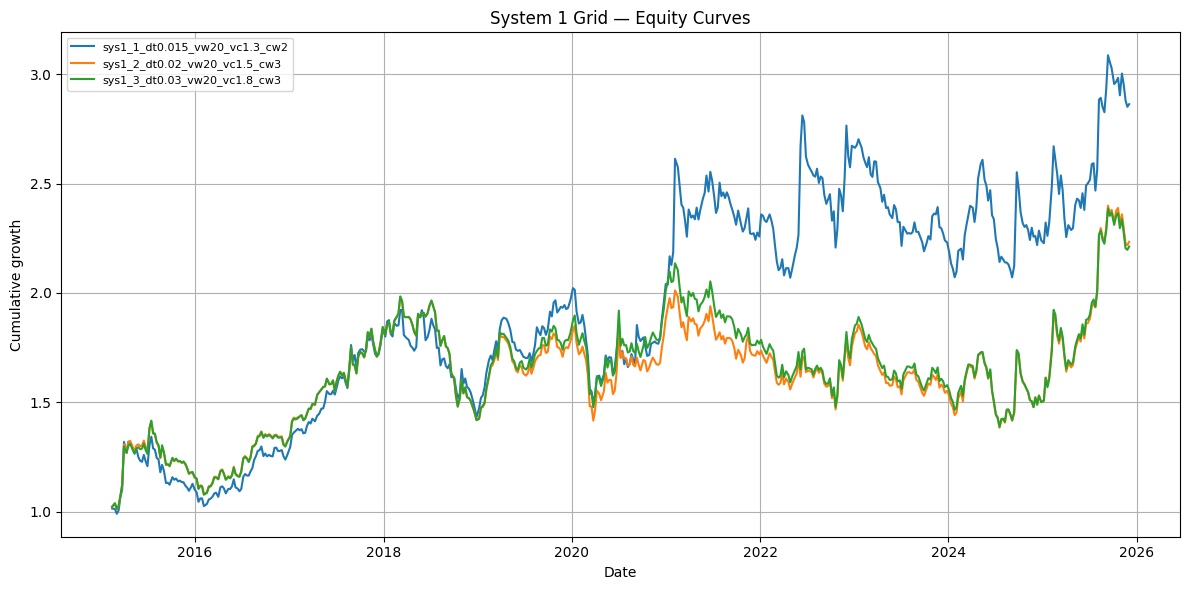

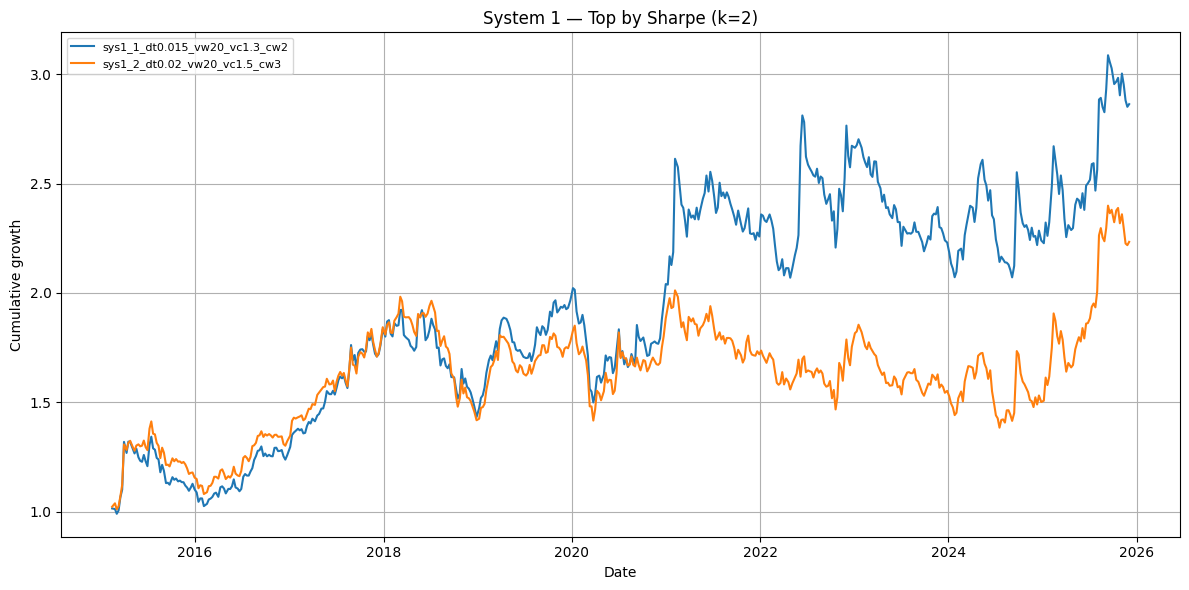

In [10]:
# 4) parameter grid for System 1
grid = [
  {"delta_tight":0.015,"vol_window":20,"vr_center":1.3,"cont_window":2},
  {"delta_tight":0.020,"vol_window":20,"vr_center":1.5,"cont_window":3},
  {"delta_tight":0.030,"vol_window":20,"vr_center":1.8,"cont_window":3},
]
# df_grid = run_system1_grid(
#     price_df, grid,
#     H=10, top_n=2,
#     rebalance_step=5,
#     exit_rule="time_or_ma10",
#     cost_bps=0,
#     use_regime_filter=True,
#     regime_mode="exclude_rebound",
# )
# print(df_grid.head(10))

# Bonus: trend duration distribution (for later System 2)
# start_event = (sig_A > 0.75)  # threshold
# episodes = compute_trend_duration_distribution(price_df, start_event)
# episodes["duration_days"].describe()

H = 5
rebalance_step = 5   # non-overlapping; if you set 1 you must change freq=252

metrics_df, curves, rets = run_grid_with_curves(
    price_df=price_df,
    grid=grid,
    H=H,
    top_n=10,
    entry_mode="next_open",
    rebalance_step=rebalance_step,
    exit_rule="time_or_ma10",
    cost_bps=0,
    use_regime_filter=True,
    regime_mode="exclude_rebound",
    base_label="sys1",
)

print(metrics_df[[
    "label","delta_tight","vol_window","vr_center","cont_window",
    "ann_return_geo","ann_vol","sharpe","max_dd","n_obs"
]])

# Plot all curves (3 lines here, so it’s readable)
plot_grid_equity_curves(curves, title="System 1 Grid — Equity Curves")

# Or plot only the top-2/3 by Sharpe
plot_topk_curves(metrics_df, curves, k=2, title_prefix="System 1 — Top by Sharpe")